In [1]:
import os
import json
from pathlib import Path
import openai
import pandas as pd
import numpy as np
import logging
from IPython.display import clear_output
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt
import re
import traceback

%matplotlib inline
%load_ext autoreload
%autoreload 2

from parse import parse

from finetuning import prepare_data
from utils import graph
from utils import utils
from nodes.node_functions import *
from utils.models_metadata import *

# playground

In [8]:
carryover_data['data_challenge_objectives_and_contraints']

'You are given data for the performance of wind turbines. Your goal is to build a model that can predict whether a turbine will break down within the next 90 days.\n- Maximize model performance.'

In [29]:
deep_get(carryover_data, ['data_challenge_objectives_and_constraints'], "NA")

'NA'

In [30]:
utils.deep_get(carryover_data, ['applicant_data', 'applicant_context'], "NA")

{'algorithm selection': 'Neural Net',
 'categorical encoding': 'hash encoding',
 'handling numerical variables': 'standard scaler',
 'dealing with missing values': 'iterative imputation'}

# setup

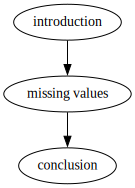

In [2]:
interview_graph = graph.create_interview_flowchart()

graph.plot_graph(interview_graph)

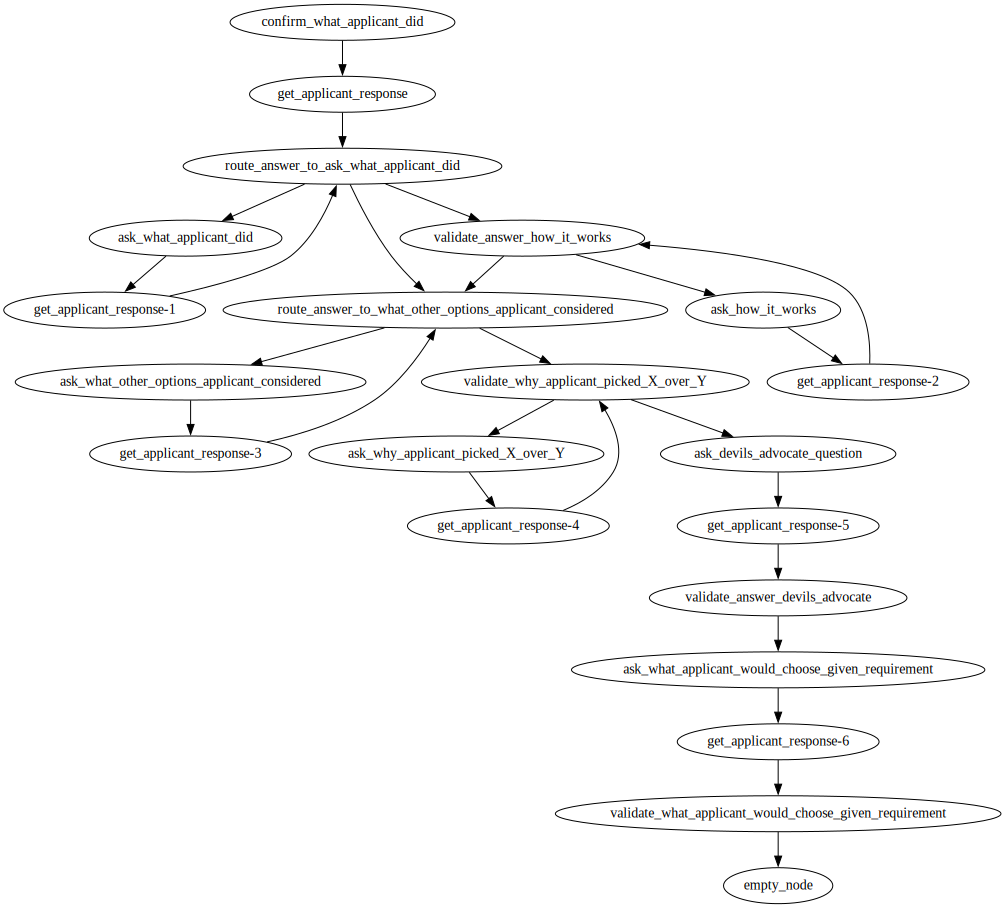

In [3]:
# graph.plot_graph(interview_graph.nodes["algorithm selection"]['graph'])

# graph.plot_graph(interview_graph.nodes["dealing with categorical values"]['graph'])

# graph.plot_graph(interview_graph.nodes["dealing with numerical values"]['graph'])

# graph.plot_graph(interview_graph.nodes["model presentation layer"]['graph'])
graph.plot_graph(interview_graph.nodes["missing values"]['graph'])


# run

In [4]:
applicant_approaches = {
    'algorithm selection': 'Neural Net',
    'categorical encoding': 'hash encoding',
    'handling numerical variables': 'standard scaler',
    'dealing with missing values': 'Last Value Carry Forward'
}
data_challenge_objectives_and_constraints = """You are given data for the performance of wind turbines. Your goal is to build a model that can predict whether a turbine will break down within the next 90 days.
- Maximize model performance."""
# - Model interpretability is not a strong requirement."""

insights = []

what_interviewer_thinks_applicant_has_done_in_ipynb = deepcopy(applicant_approaches)

carryover_data = {
    "applicant_data": {"applicant_skill_summary": {"technical_depth": np.random.randint(1, 4),
                                                "technical_breadth": np.random.randint(1, 4),
                                                "critical_thinking": np.random.randint(1, 4)},
                       "applicant_context": applicant_approaches,
                       'insights': insights,
                      },
    "what_interviewer_thinks_applicant_has_done_in_ipynb": what_interviewer_thinks_applicant_has_done_in_ipynb,
    "data_challenge_objectives_and_constraints": data_challenge_objectives_and_constraints,
    "insights": insights,
    'sections': {'missing values': {'ask_what_applicant_would_choose_given_requirement': {'prompt_args': {}}}}
}

# each list within this variable is the conversation in a particular section. each string within that list is the ordered dialogue from each member of the interview
chat_history_by_section = []
flattened_chat_history = ""

# list of the nodes that have been visited till the current point
sections_visited_names = []
nodes_visited_names = []

validate_async = False
is_interview_complete = False


current_section_name, current_section = graph.get_first_node_in_graph(interview_graph)
current_section_graph = current_section['graph']

In [5]:

try:
    # traverse through sections
    while not is_interview_complete:
        chat_history_by_section.append([])
        current_node_name, current_node = graph.get_first_node_in_graph(current_section_graph)
        # print("\n\ncurrent section: " + current_section_name)
        # print("current node: " + current_node_name)
        is_section_complete = False
        # traverse within section
        while not is_section_complete:
            # access current node from current section
            # prep args for current node function
            current_node_function_args = deepcopy(current_node['function_args']) if 'function_args' in current_node else {}
            current_node_function_args['current_section_name'] = current_section_name
            current_node_function_args['carryover_data'] = carryover_data
            current_node_function_args['validate_async'] = validate_async
            current_node_function_args['chat_history_by_section'] = chat_history_by_section

            # call function
            current_node_output = current_node['function'](**current_node_function_args)
            
            if current_node_output['new_chat_lines']:
                # store return values in appropriate variables (chat_history)
                chat_history_by_section[-1].extend(current_node_output['new_chat_lines'])
                flattened_chat_history += "\n" + "\n".join(current_node_output['new_chat_lines'])
                clear_output()
                print(flattened_chat_history)
        
            # update nodes_visited
            nodes_visited_names.append(current_node_name)
        
            # figure out next node to visit
            current_node_name, current_node = graph.get_next_node(current_section_graph, current_node_name, current_node_output)
            if current_node_name is None:
                # prepare routing_value (result of a section)
                current_section_output = dict(routing_value=1, 
                                            new_chat_line=None) 
                is_section_complete = True

        
        sections_visited_names.append(current_section_name)
        # get new section
        current_section_name, current_section = graph.get_next_node(interview_graph, current_section_name, current_section_output)
        if current_section_name is None:
            is_interview_complete = True
            break
        current_section_graph = current_section['graph']
except:
    traceback.print_exc()


Interviewer: Thank you for taking the time out to interview with us. 
    In this interview, we will cover a range of topics and ask questions to assess your skill level as a Data Scientist. 
    If you don't understand a question, feel free to ask questions to get clarification.
    Let's get started.
Interviewer: From your submission, I saw that you used Last Value Carry Forward to handle missing values in the dataset. Is that right?
Applicant: Yes, I used Last Value Carry Forward to handle missing values in the dataset.
Interviewer: How does Last Value Carry Forward work?
Applicant: Last Value Carry Forward is a technique used to replace missing values with the last value seen before the missing value.
Interviewer: Other than Last Value Carry Forward, what other techniques did you consider for dealing with the missing values?
Applicant: I also considered removing observations with missing values.
Interviewer: Why did you choose to use Last Value Carry Forward instead of removing ob

In [8]:
# prepare_data.validate_observations_for_finetuning_from_queue()

# debug

In [19]:
current_node_name

'validate_answer_devils_advocate'

In [15]:
# try:
#     # interview_graph.nodes["algorithm selection"]['graph'].nodes['ask_how_it_works']['function_args']['subject'] = "DBSCAN"

#     # current_node = interview_graph.nodes["algorithm selection"]['graph'].nodes["validate_why_applicant_picked_X_over_Y"]

#     current_node_function_args = deepcopy(current_node['function_args']) if 'function_args' in current_node else {}
#     current_node_function_args['carryover_data'] = carryover_data
#     current_node_function_args['current_section_name'] = "dealing with numerical values"
#     current_node_function_args['validate_async'] = False
#     # current_node_function_args['chat_history_by_section'] = [
#     #     ["""Interviewer: Could you confirm whether you used a Generative Adversarial Network for this task?
#     # Applicant: Yes, I used a Generative Adversarial Network for this task.
#     # Interviewer: How does a Generative Adversarial Network work?
#     # Applicant: GANs are deep learning models that produce fake data.
#     # Interviewer: Besides GANs, did you consider any other algorithms for this task?
#     # Applicant: Yes, I considered using autoencoders and also CNNs."""]
#     # ]
#     current_node_function_args['chat_history_by_section'] = chat_history_by_section

#     current_node_output = current_node['function'](**current_node_function_args)
# except:
#     traceback.print_exc()
